In [103]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import PyLyrics as lyrics
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from time import time, sleep
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
# import sys
# sys.version

In [104]:
with open('../data/creds.json', 'r') as f:
    creds = json.load(f)
    client_id = creds["id"]
    client_secret = creds["secret"]

spotify_green = '#1db954'
spotify_black = '#191414'

In [126]:
class Dataset:
    def __init__(self, client_id, client_secret):
        client_cred = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=client_secret)
        self.sp = spotipy.Spotify(client_credentials_manager=client_cred)
        self.data_dict = {'__disclaimer': "I do not own any of the data included here, and intend to use this for academic purposes only.", 
                          'tracks':  {}, 
                          'users':   {},
                          'albums':  {}
                          }

    def size(self):
        return len(self.data_dict['tracks'])
    
    def num_users(self):
        return len(self.data_dict['users'])
                        
    def load_data(self, data_filepath):
        with open(data_filepath, 'r') as f:
            self.data_dict = json.load(f)

    def save_data(self, data_filepath):
        with open(data_filepath, 'w') as f:
            json.dump(self.data_dict, f)

    def fetch_user_data(self, user_id, get_artist_tracks=False):
        user_playlists = self.sp.user_playlists(user_id)

        for playlist in user_playlists['items']:
            if playlist['owner']['id'] == user_id:
                print(playlist['name'], end='')
                print(' -- ', playlist['tracks']['total'])
                results = self.sp.user_playlist(user_id, playlist['id'], fields='tracks,next')
                tracks = results['tracks']
                for i, item in enumerate(tracks['items']):
                    track = item['track']
                    # pprint(track)
                    self.add_data(user_id, track)
                while tracks['next']:
                    tracks = self.sp.next(tracks)
                    for i, item in enumerate(tracks['items']):
                        track = item['track']
                        # pprint(track)
                        self.add_data(user_id, track)
        user_tracks = self.data_dict['users'][user_id]
        self.data_dict['users'][user_id] = list(set(user_tracks))

    def add_data(self, user_id, track_obj):
        track_name = track_obj['name']
        track_id = track_obj['id']
        if user_id in self.data_dict['users']:
            self.data_dict['users'][user_id].append(track_id)
        else:
            self.data_dict['users'][user_id] = [track_id]
        artist_id = track_obj['artists'][0]['id']
        artist = track_obj['artists'][0]['name']
        if len(artist)==0: 
            return
        if track_id in self.data_dict['tracks']:
            # print("track info already present:", track_name, ":", artist)
            return
        else:
            # pprint(track_audio_feats)
            # track_audio_analysis = self.sp.audio_analysis(track_id) # too slow
            # pprint(track_audio_analysis)
            if len(track_name) == 0: 
                return
            track_data = self.get_feats(artist, track_obj)
            track_data['artist_id'] = artist_id
            self.data_dict['tracks'][track_id] = track_data
        
    def get_feats(self, artist, track):
        track_id = track['id']
        track_name = track['name'].strip()
        artist_id = track['artists'][0]['id']
        album_name = track['album']['name'].strip()
        track_duration = track['duration_ms']/1000
        track_audio_feats = self.sp.audio_features(track_id)[0]
        track_popularity = track['popularity']
        album_id = track['album']['id']
        if album_id in self.data_dict['albums']:
            # print("Album info already present: ", album_name, "-", artist)
            album_info = self.data_dict['albums'][album_id]
        else:
            album_data = self.sp.album(album_id)
            album_info = {'name': album_name,
                          'release_year': album_data['release_date'][:4],
                          'popularity': album_data['popularity'],
                          'album_art': [i['url'] for i in track['album']['images']][0],
                          'genres': album_data['genres'],
                          'artist': artist,
                          'artist_id': artist_id}
            self.data_dict['albums'][album_id] = album_info
        release_year = album_info['release_year']
        genres = album_info['genres']
        
        for i in ['uri', 'id', 'analysis_url', 'track_href', 'type', 'duration_ms']:
            del track_audio_feats[i]
        track_lyrics = 'N/A'
        try:
            track_lyrics = lyrics.PyLyrics.getLyrics(artist, track_name)
        except ValueError as e:
            track_name = track_name.split('-')[0].strip()
            try:
                track_lyrics = lyrics.PyLyrics.getLyrics(artist, track_name)
            except ValueError as e:
                print('Lyrics not found for %s - %s'%(artist, track_name))
        track_data = {'name': track_name, 
                      'artist': artist,
                      'album': album_name,
                      'album_id': album_id,
                      'popularity': track_popularity,
                      'release_year': release_year,
                      'genres': genres,
                      'duration': track_duration, 
                      'lyrics': track_lyrics, 
                      'audio_feats': track_audio_feats}
        return track_data

In [127]:
dataset = Dataset(client_id, client_secret)
dataset.load_data('../data/spotify_data.json')

In [128]:
tic = time()
for user in ['ajinkyaz']:
    dataset.fetch_user_data(user)
print('Took ', time()-tic, 'seconds')

Random Shite --  146
Schoolboy --  88
Git off my lawn! --  114
Soundtrack Music --  47
Took  2.008936882019043 seconds


In [129]:
print('Total tracks --', dataset.size())
print('Total users --', dataset.num_users())

Total tracks -- 375
Total users -- 1


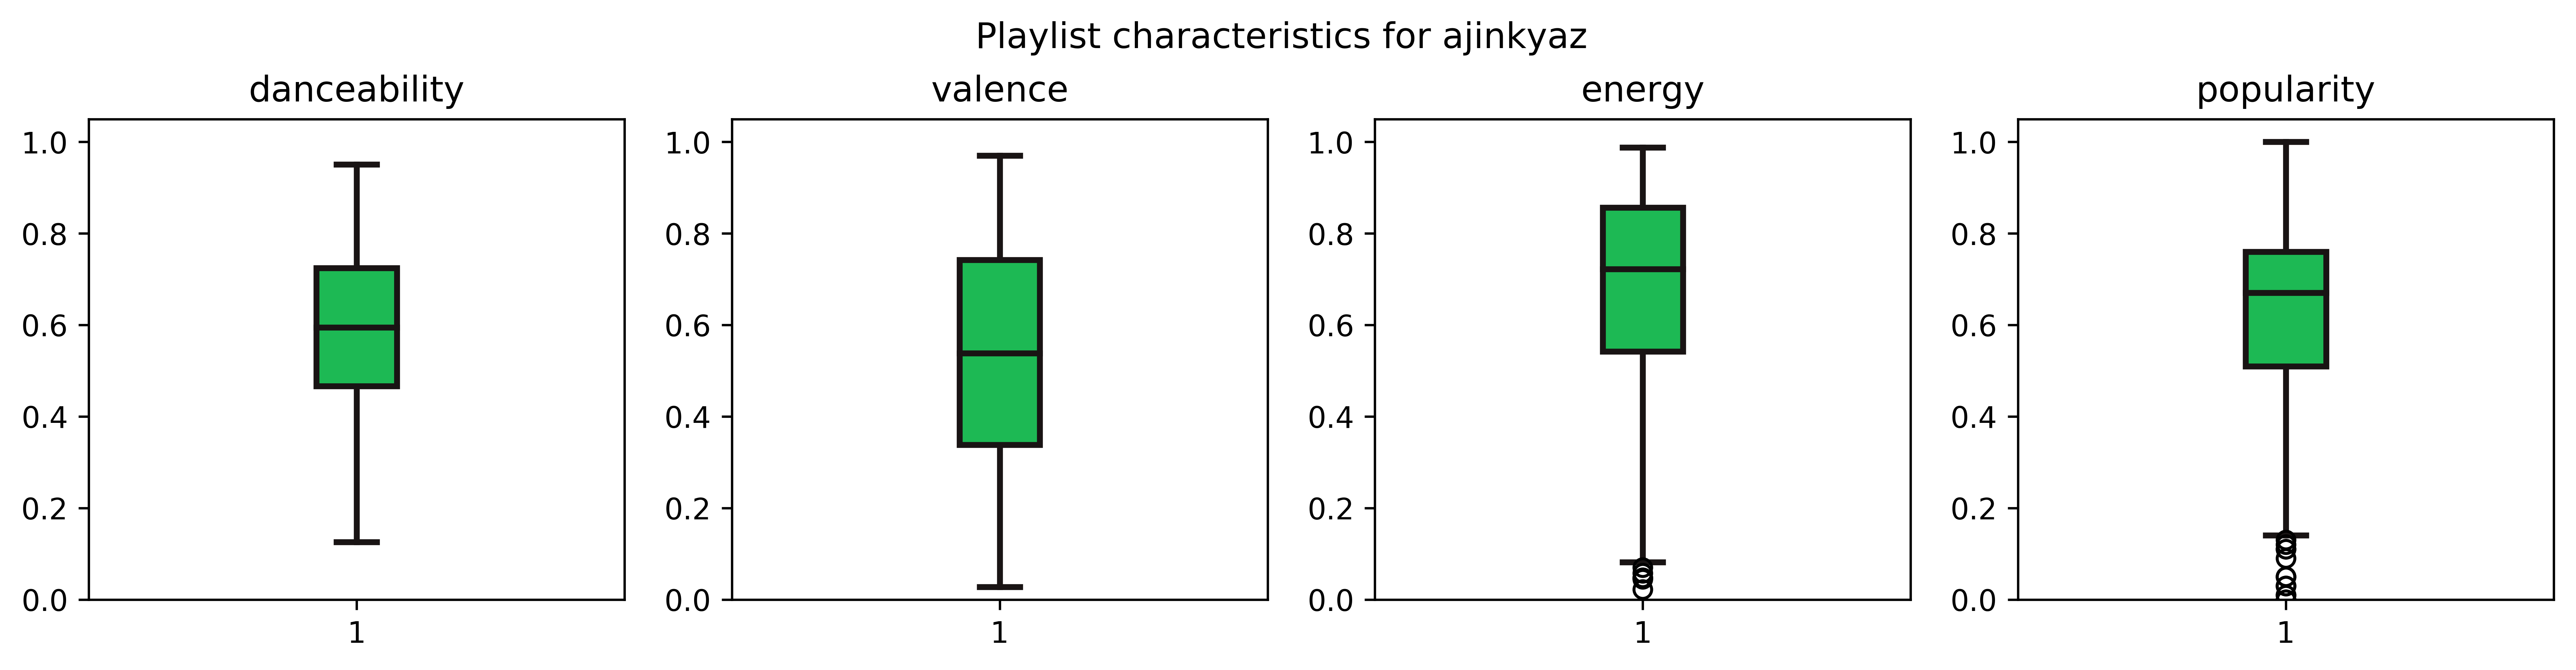

In [130]:
user_stats = {}
for user, user_tracks in dataset.data_dict['users'].items():
    user_stats[user] = {'valence': [], 'popularity': [], 'energy': [], 'danceability': []}
    for i in list(set(user_tracks)):
        if i not in dataset.data_dict['tracks']: continue
        val_track = dataset.data_dict['tracks'][i]['audio_feats']['valence']
        pop_track = dataset.data_dict['tracks'][i]['popularity']
        dance_track = dataset.data_dict['tracks'][i]['audio_feats']['danceability']
        energy_track = dataset.data_dict['tracks'][i]['audio_feats']['energy']
        user_stats[user]['valence'].append(val_track)
        user_stats[user]['popularity'].append(pop_track)
        user_stats[user]['danceability'].append(dance_track)
        user_stats[user]['energy'].append(energy_track)

    ax = {}
    fig = plt.figure(figsize=(15, 3), dpi=600)
    plt.suptitle('Playlist characteristics for %s'%user, verticalalignment='bottom')

    for k, v in user_stats[user].items():
        v = np.array(v)
        # print(len(v))
        num = 140+len(ax)+1 # 1 row, 4 cols, pos
        if np.max(v)>10: # if values are in 0-100 range
            v = v*0.01   # scale to 0 - 1
        ax[k] = fig.add_subplot(num)
        ax[k].set_ylim([0.0, 1.05])
        ax[k].title.set_text(k)
        
        #styling
        bp = ax[k].boxplot(v, patch_artist=True)
        for box in bp['boxes']:
            box.set_edgecolor(spotify_black)
            box.set_facecolor(spotify_green)
            box.set_linewidth(2)
        for med in bp['medians']:
            med.set_linewidth(2)
            med.set_color(spotify_black)
        for whisker in bp['whiskers']:
            whisker.set_linewidth(2)
            whisker.set_color(spotify_black)
        for cap in bp['caps']:
            cap.set_linewidth(2)
            cap.set_color(spotify_black)
    plt.show()